# MANA-10: Tissue area per sample (alpha shape)

Compute concave (alpha-shape) area for each `sample_id` using spatial coordinates.
Adjust the data path and `alpha` settings as needed.


In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
from scipy.spatial import Delaunay, cKDTree
import matplotlib.pyplot as plt


In [55]:
# Load your AnnData
# If you're coming from MANA-9, you can skip this and reuse `ad`.
ad = sc.read_h5ad('/Volumes/processing2/RRmap/data/EAE_MANA_annotated_gmm_clust_with_scores_anno_comp.h5ad')
ad = ad[ad.obs['compartment_mana'] != 'dorsal root ganglion']   # Exclude unwanted compartment

In [56]:
def _alpha_from_knn(points, k=10, quantile=0.5):
    if len(points) <= k:
        return None
    tree = cKDTree(points)
    dists, _ = tree.query(points, k=k + 1)
    # Use distance to the k-th neighbor (skip self at index 0)
    kth = dists[:, -1]
    scale = np.quantile(kth, quantile)
    if not np.isfinite(scale) or scale <= 0:
        return None
    # Alpha is inverse scale (smaller scale -> larger alpha -> tighter shape)
    return 1.0 / scale


def alpha_shape_area(points, alpha=None):
    if points.shape[0] < 4:
        return 0.0
    if alpha is None:
        alpha = _alpha_from_knn(points)
    if alpha is None:
        return 0.0

    tri = Delaunay(points)
    simplices = tri.simplices

    pts = points[simplices]
    a = np.linalg.norm(pts[:, 0] - pts[:, 1], axis=1)
    b = np.linalg.norm(pts[:, 1] - pts[:, 2], axis=1)
    c = np.linalg.norm(pts[:, 2] - pts[:, 0], axis=1)

    s = (a + b + c) / 2.0
    area = np.sqrt(np.maximum(s * (s - a) * (s - b) * (s - c), 0.0))

    # Circumradius R = a*b*c / (4*area)
    with np.errstate(divide='ignore', invalid='ignore'):
        circum_r = (a * b * c) / (4.0 * area)
    keep = np.isfinite(circum_r) & (circum_r < (1.0 / alpha)) & (area > 0)

    return float(area[keep].sum())


In [57]:
# Filter out spatial outliers using kNN distance
def filter_points_knn(points, k=10, quantile=0.98):
    if points.shape[0] <= k:
        mask = np.ones(points.shape[0], dtype=bool)
        return points, mask
    tree = cKDTree(points)
    dists, _ = tree.query(points, k=k + 1)
    kth = dists[:, -1]
    cutoff = np.quantile(kth, quantile)
    mask = kth <= cutoff
    return points[mask], mask

# Tweak these defaults if needed
knn_k = 10
knn_quantile = 0.98


In [58]:
# KDE + contour area
from scipy.stats import gaussian_kde

def _contour_area_from_paths(paths):
    if not paths:
        return 0.0, None
    areas = []
    for path in paths:
        v = path.vertices
        if v.shape[0] < 3:
            continue
        x = v[:, 0]
        y = v[:, 1]
        area = 0.5 * abs((x * np.roll(y, -1) - y * np.roll(x, -1)).sum())
        areas.append((area, v))
    if not areas:
        return 0.0, None
    area, verts = max(areas, key=lambda t: t[0])
    return float(area), verts


def kde_contour_area(points, bw_method='scott', gridsize=200, level_quantile=0.1):
    if points.shape[0] < 5:
        return 0.0, None
    kde = gaussian_kde(points.T, bw_method=bw_method)
    xmin, ymin = points.min(axis=0)
    xmax, ymax = points.max(axis=0)
    pad_x = 0.05 * (xmax - xmin) if xmax > xmin else 1.0
    pad_y = 0.05 * (ymax - ymin) if ymax > ymin else 1.0
    xmin -= pad_x
    xmax += pad_x
    ymin -= pad_y
    ymax += pad_y

    xs = np.linspace(xmin, xmax, gridsize)
    ys = np.linspace(ymin, ymax, gridsize)
    xx, yy = np.meshgrid(xs, ys)
    zz = kde(np.vstack([xx.ravel(), yy.ravel()])).reshape(xx.shape)

    level = np.quantile(zz, level_quantile)
    fig = plt.figure()
    try:
        cs = plt.contour(xx, yy, zz, levels=[level])
        paths = []
        # Matplotlib compatibility: use collections if available, else allsegs
        if hasattr(cs, 'collections') and cs.collections:
            paths = cs.collections[0].get_paths()
        elif hasattr(cs, 'allsegs') and cs.allsegs:
            # allsegs[0] is list of (n,2) arrays for the first level
            paths = [type('P', (), {'vertices': seg}) for seg in cs.allsegs[0] if len(seg) > 0]
        area, verts = _contour_area_from_paths(paths)
    finally:
        plt.close(fig)
    return area, verts

# Tweak these defaults if needed
kde_bw = 'scott'
kde_gridsize = 200
kde_level_quantile = 0.1


In [59]:
# Compute area per sample_id
spatial_key = 'spatial'
sample_key = 'sample_id'

if spatial_key not in ad.obsm:
    raise KeyError(f"Missing {spatial_key!r} in ad.obsm")
if sample_key not in ad.obs:
    raise KeyError(f"Missing {sample_key!r} in ad.obs")

coords = np.asarray(ad.obsm[spatial_key])[:, :2]
samples = ad.obs[sample_key].astype('category')

rows = []
for sample in samples.cat.categories:
    idx = np.where(samples == sample)[0]
    pts = coords[idx]
    area, _ = kde_contour_area(
        pts, bw_method=kde_bw, gridsize=kde_gridsize, level_quantile=kde_level_quantile
    )
    rows.append({
        'sample_id': sample,
        'n_cells_total': len(idx),
        'area': area,
    })

area_df = pd.DataFrame(rows).sort_values('area', ascending=False)
area_df


,sample_id,n_cells_total,area
4,G6_L3_0,7582,765200.385747
104,S2_T2_1,13084,443121.560889
77,S3_B2_0,14689,378786.623212
76,S1_T2_2,9286,333728.659813
41,G3_L3_2,4814,330685.354096
...,...,...,...
42,G5_L1_0,2783,21332.370727
84,S4_T3_2,5746,20956.704600
92,S4_T1_1,8088,19172.558472
0,G4_L1_0,3486,12985.189906


<Figure size 1000x600 with 0 Axes>

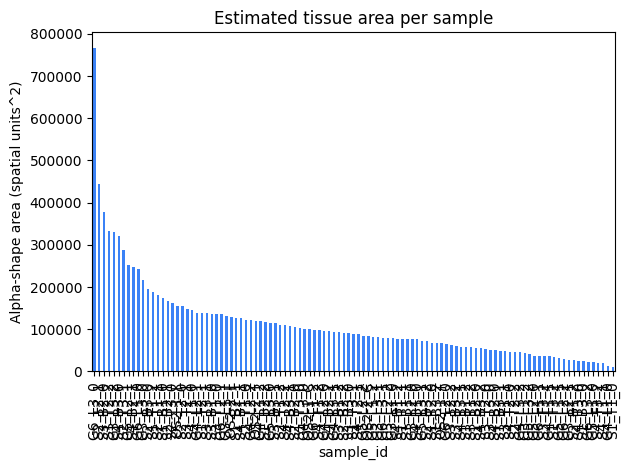

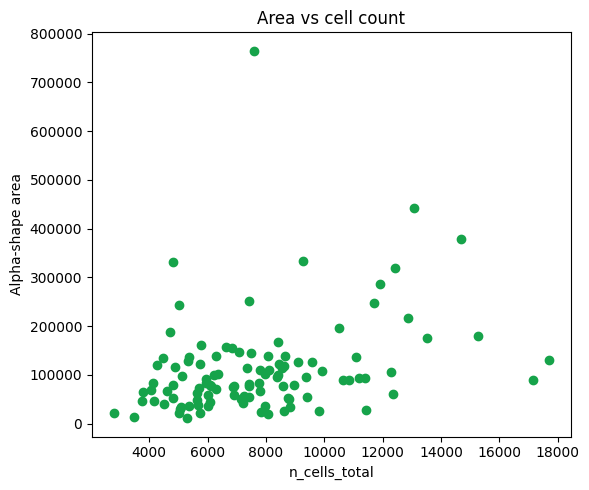

In [60]:
# Quick visuals
plt.figure(figsize=(10, 6))
ax = area_df.sort_values('area', ascending=False).plot(
    x='sample_id', y='area', kind='bar', legend=False, color='#3B82F6'
)
ax.set_xlabel('sample_id')
ax.set_ylabel('Alpha-shape area (spatial units^2)')
ax.set_title('Estimated tissue area per sample')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
ax = plt.scatter(area_df['n_cells_total'], area_df['area'], c='#16A34A')
plt.xlabel('n_cells_total')
plt.ylabel('Alpha-shape area')
plt.title('Area vs cell count')
plt.tight_layout()
plt.show()


<Figure size 1000x500 with 0 Axes>

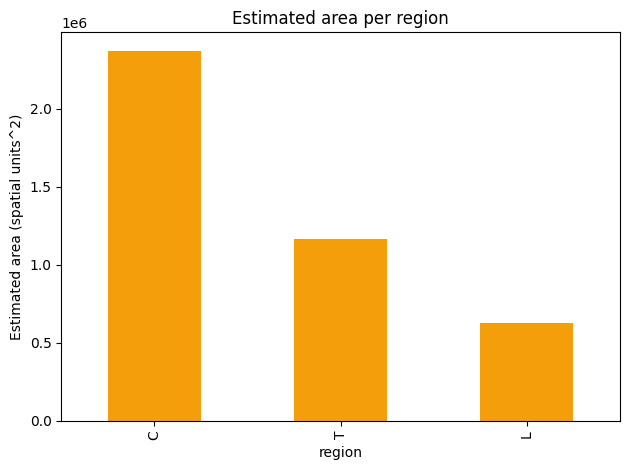

In [61]:
# Area per region (KDE + contour)
region_key = 'region'

if region_key not in ad.obs:
    raise KeyError(f"Missing {region_key!r} in ad.obs")

coords = np.asarray(ad.obsm[spatial_key])[:, :2]
regions = ad.obs[region_key].astype('category')

rows = []
for region in regions.cat.categories:
    idx = np.where(regions == region)[0]
    pts = coords[idx]
    area, _ = kde_contour_area(
        pts, bw_method=kde_bw, gridsize=kde_gridsize, level_quantile=kde_level_quantile
    )
    rows.append({
        region_key: region,
        'n_cells_total': len(idx),
        'area': area,
    })

region_areas = pd.DataFrame(rows).sort_values('area', ascending=False)
region_areas

plt.figure(figsize=(10, 5))
ax = region_areas.sort_values('area', ascending=False).plot(
    x=region_key,
    y='area',
    kind='bar',
    color='#F59E0B',
    legend=False
)
ax.set_xlabel(region_key)
ax.set_ylabel('Estimated area (spatial units^2)')
ax.set_title('Estimated area per region')
plt.tight_layout()
plt.show()


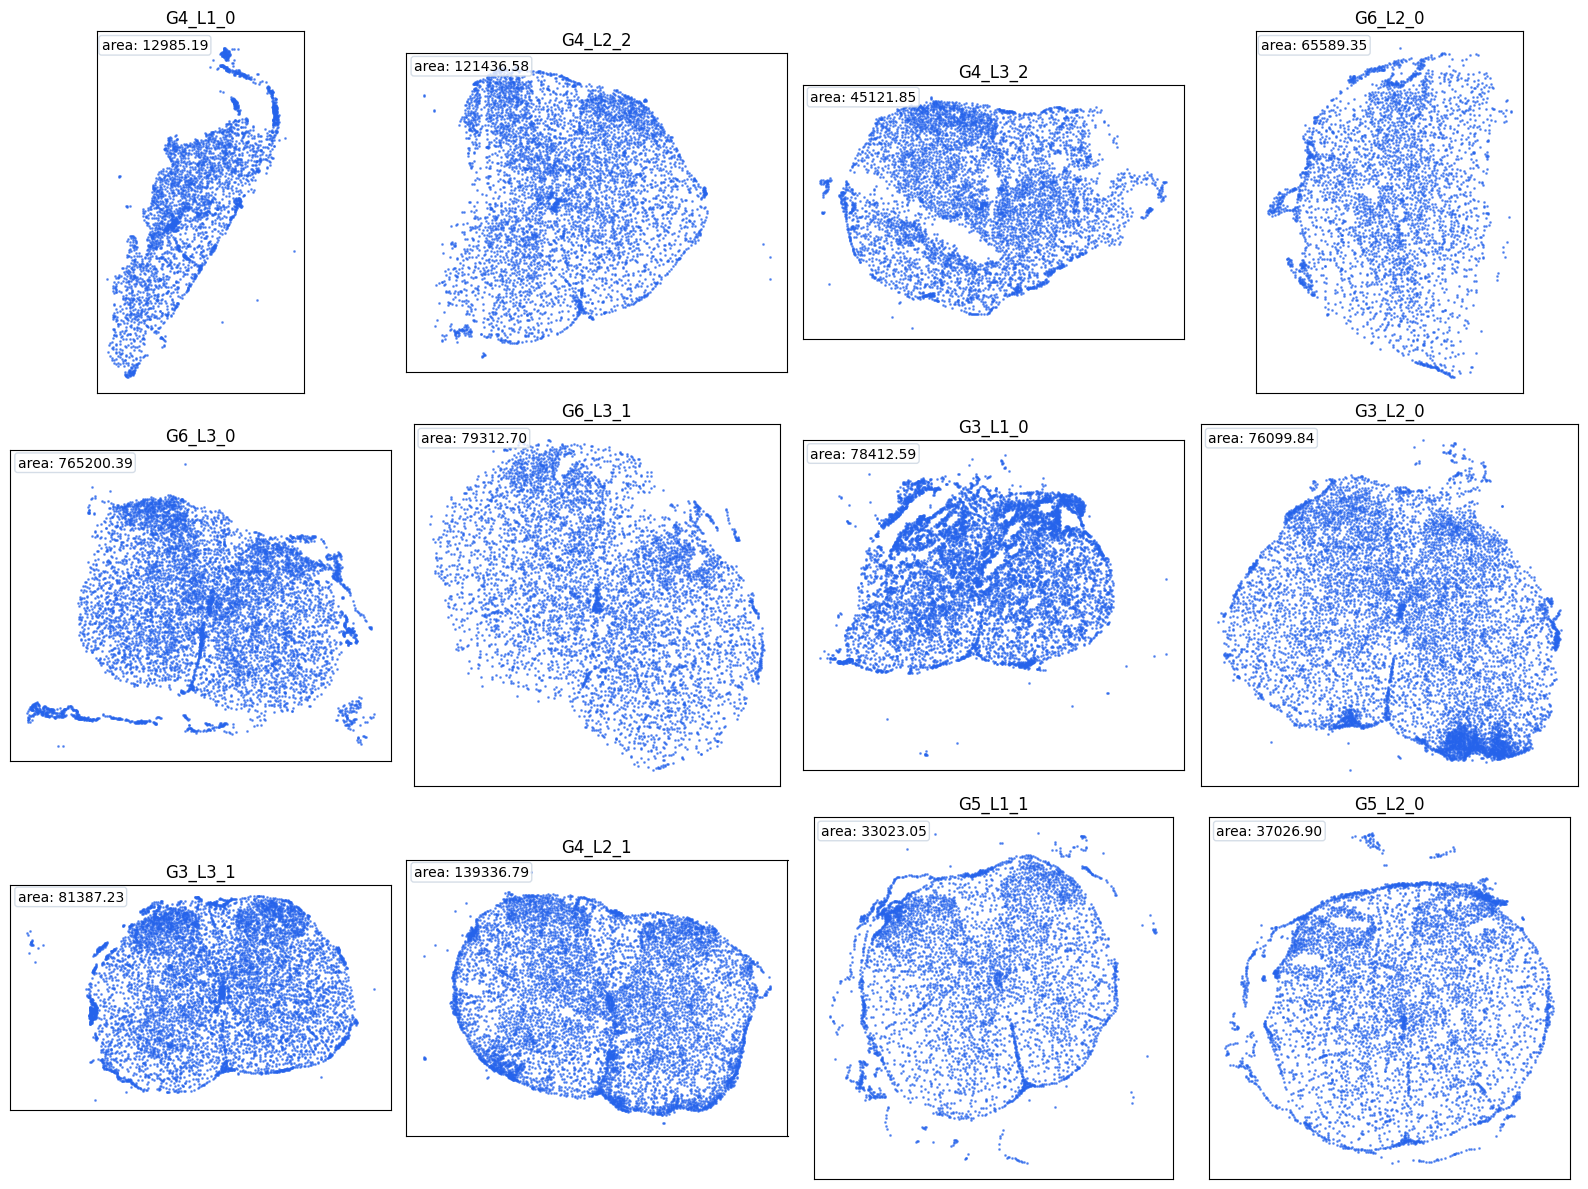

In [62]:
# Per-sample spatial scatter with area annotation
import math

# Ensure area_df exists (run the area computation cell first)
if 'area_df' not in globals():
    raise RuntimeError('Run the area computation cell to create area_df first.')

coords = np.asarray(ad.obsm[spatial_key])[:, :2]
samples = ad.obs[sample_key].astype('category')

# Plot a subset or all samples
max_samples = 12  # adjust as needed
sample_list = list(samples.cat.categories)[:max_samples]

n = len(sample_list)
cols = 4
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows), squeeze=False)

for ax, sample in zip(axes.flatten(), sample_list):
    idx = np.where(samples == sample)[0]
    pts = coords[idx]
    ax.scatter(pts[:, 0], pts[:, 1], s=1, alpha=0.6, color='#2563EB')
    area_val = area_df.loc[area_df['sample_id'] == sample, 'area']
    area_text = area_val.iloc[0] if not area_val.empty else float('nan')
    ax.text(
        0.02, 0.98,
        f'area: {area_text:.2f}',
        transform=ax.transAxes,
        ha='left', va='top',
        fontsize=10,
        bbox={'boxstyle': 'round,pad=0.2', 'facecolor': 'white', 'alpha': 0.8, 'edgecolor': '#CBD5E1'},
    )
    ax.set_title(str(sample))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')

# Hide unused axes
for ax in axes.flatten()[len(sample_list):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


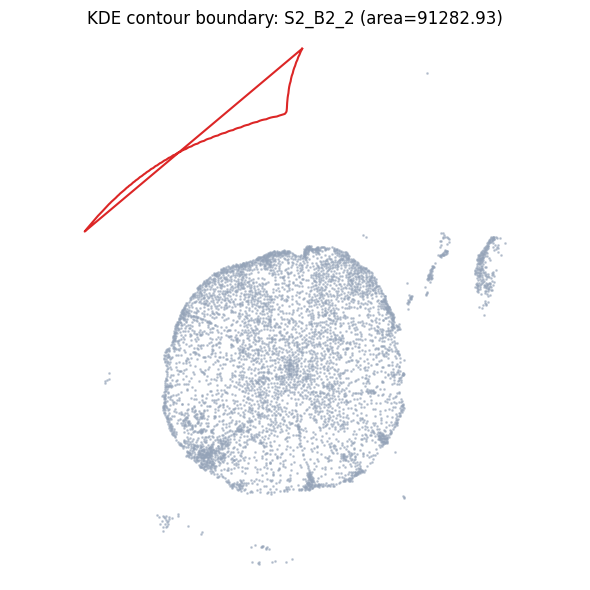

In [66]:
# Plot KDE contour boundary for a single sample
sample_to_plot = samples.cat.categories[50]
idx = np.where(samples == sample_to_plot)[0]
pts = coords[idx]
area, verts = kde_contour_area(
    pts, bw_method=kde_bw, gridsize=kde_gridsize, level_quantile=kde_level_quantile
)

plt.figure(figsize=(6, 6))
plt.scatter(pts[:, 0], pts[:, 1], s=1, alpha=0.5, color='#94A3B8')
if verts is not None:
    loop = np.vstack([verts, verts[0]])
    plt.plot(loop[:, 0], loop[:, 1], color='#DC2626', linewidth=1.5)

plt.title(f'KDE contour boundary: {sample_to_plot} (area={area:.2f})')
plt.axis('equal')
plt.axis('off')
plt.tight_layout()
plt.show()


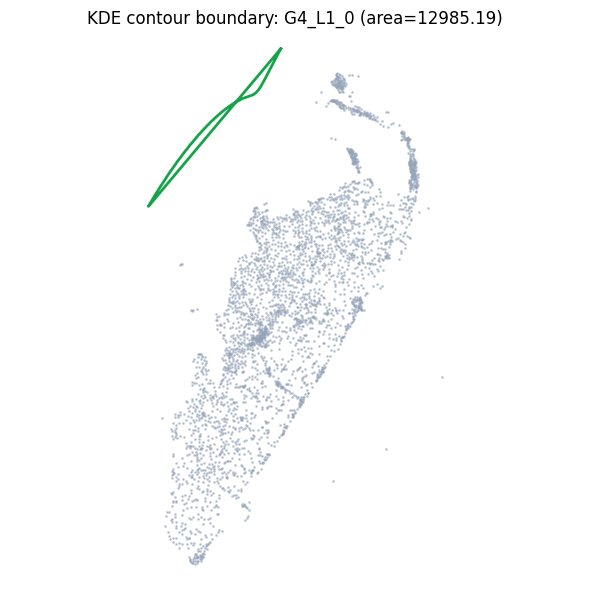

In [64]:
# Plot KDE contour boundary (outer only)
sample_to_plot = samples.cat.categories[0]
idx = np.where(samples == sample_to_plot)[0]
pts = coords[idx]
area, verts = kde_contour_area(
    pts, bw_method=kde_bw, gridsize=kde_gridsize, level_quantile=kde_level_quantile
)

plt.figure(figsize=(6, 6))
plt.scatter(pts[:, 0], pts[:, 1], s=1, alpha=0.5, color='#94A3B8')
if verts is not None:
    loop = np.vstack([verts, verts[0]])
    plt.plot(loop[:, 0], loop[:, 1], color='#16A34A', linewidth=2)

plt.title(f'KDE contour boundary: {sample_to_plot} (area={area:.2f})')
plt.axis('equal')
plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
# DBSCAN eps diagnostic (k-distance plot)
from sklearn.neighbors import NearestNeighbors

k = 10  # same as min_samples (or min_samples - 1)
sample_to_plot = samples.cat.categories[0]
idx = np.where(samples == sample_to_plot)[0]
pts = coords[idx]

nn = NearestNeighbors(n_neighbors=k).fit(pts)
dists, _ = nn.kneighbors(pts)
k_dist = np.sort(dists[:, -1])

plt.figure(figsize=(6, 4))
plt.plot(k_dist, color='#2563EB')
plt.xlabel('Points sorted by distance')
plt.ylabel(f'{k}-NN distance')
plt.title(f'k-distance plot for {sample_to_plot}')
plt.tight_layout()
plt.show()
